In [83]:
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' # для более четкой отрисовки графиков

In [134]:
ds = pd.read_csv('diabetes.csv', index_col=0) # загружаем данные
print('Размер датасета: {}'.format(ds.shape))

Размер датасета: (768, 9)


In [28]:
ds.dtypes # типы переменных

pregnant      int64
plasma        int64
pressure      int64
skin          int64
insulin       int64
mass        float64
pedigree    float64
age           int64
target        int64
dtype: object

In [29]:
ds.isna().sum()

pregnant    0
plasma      0
pressure    0
skin        0
insulin     0
mass        0
pedigree    0
age         0
target      0
dtype: int64

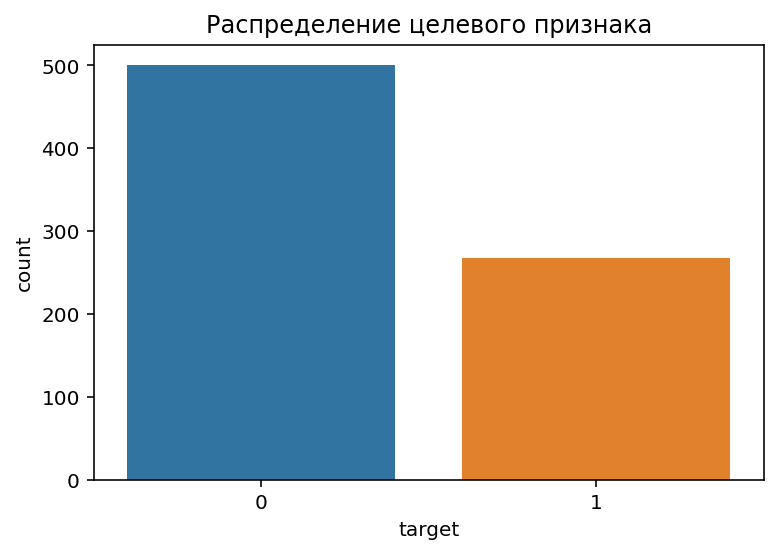

In [30]:
sns.countplot(x=ds['target']).set_title('Распределение целевого признака');

In [50]:
ds['target'].value_counts(normalize=True) # соотношение целевого признака

0    0.651042
1    0.348958
Name: target, dtype: float64

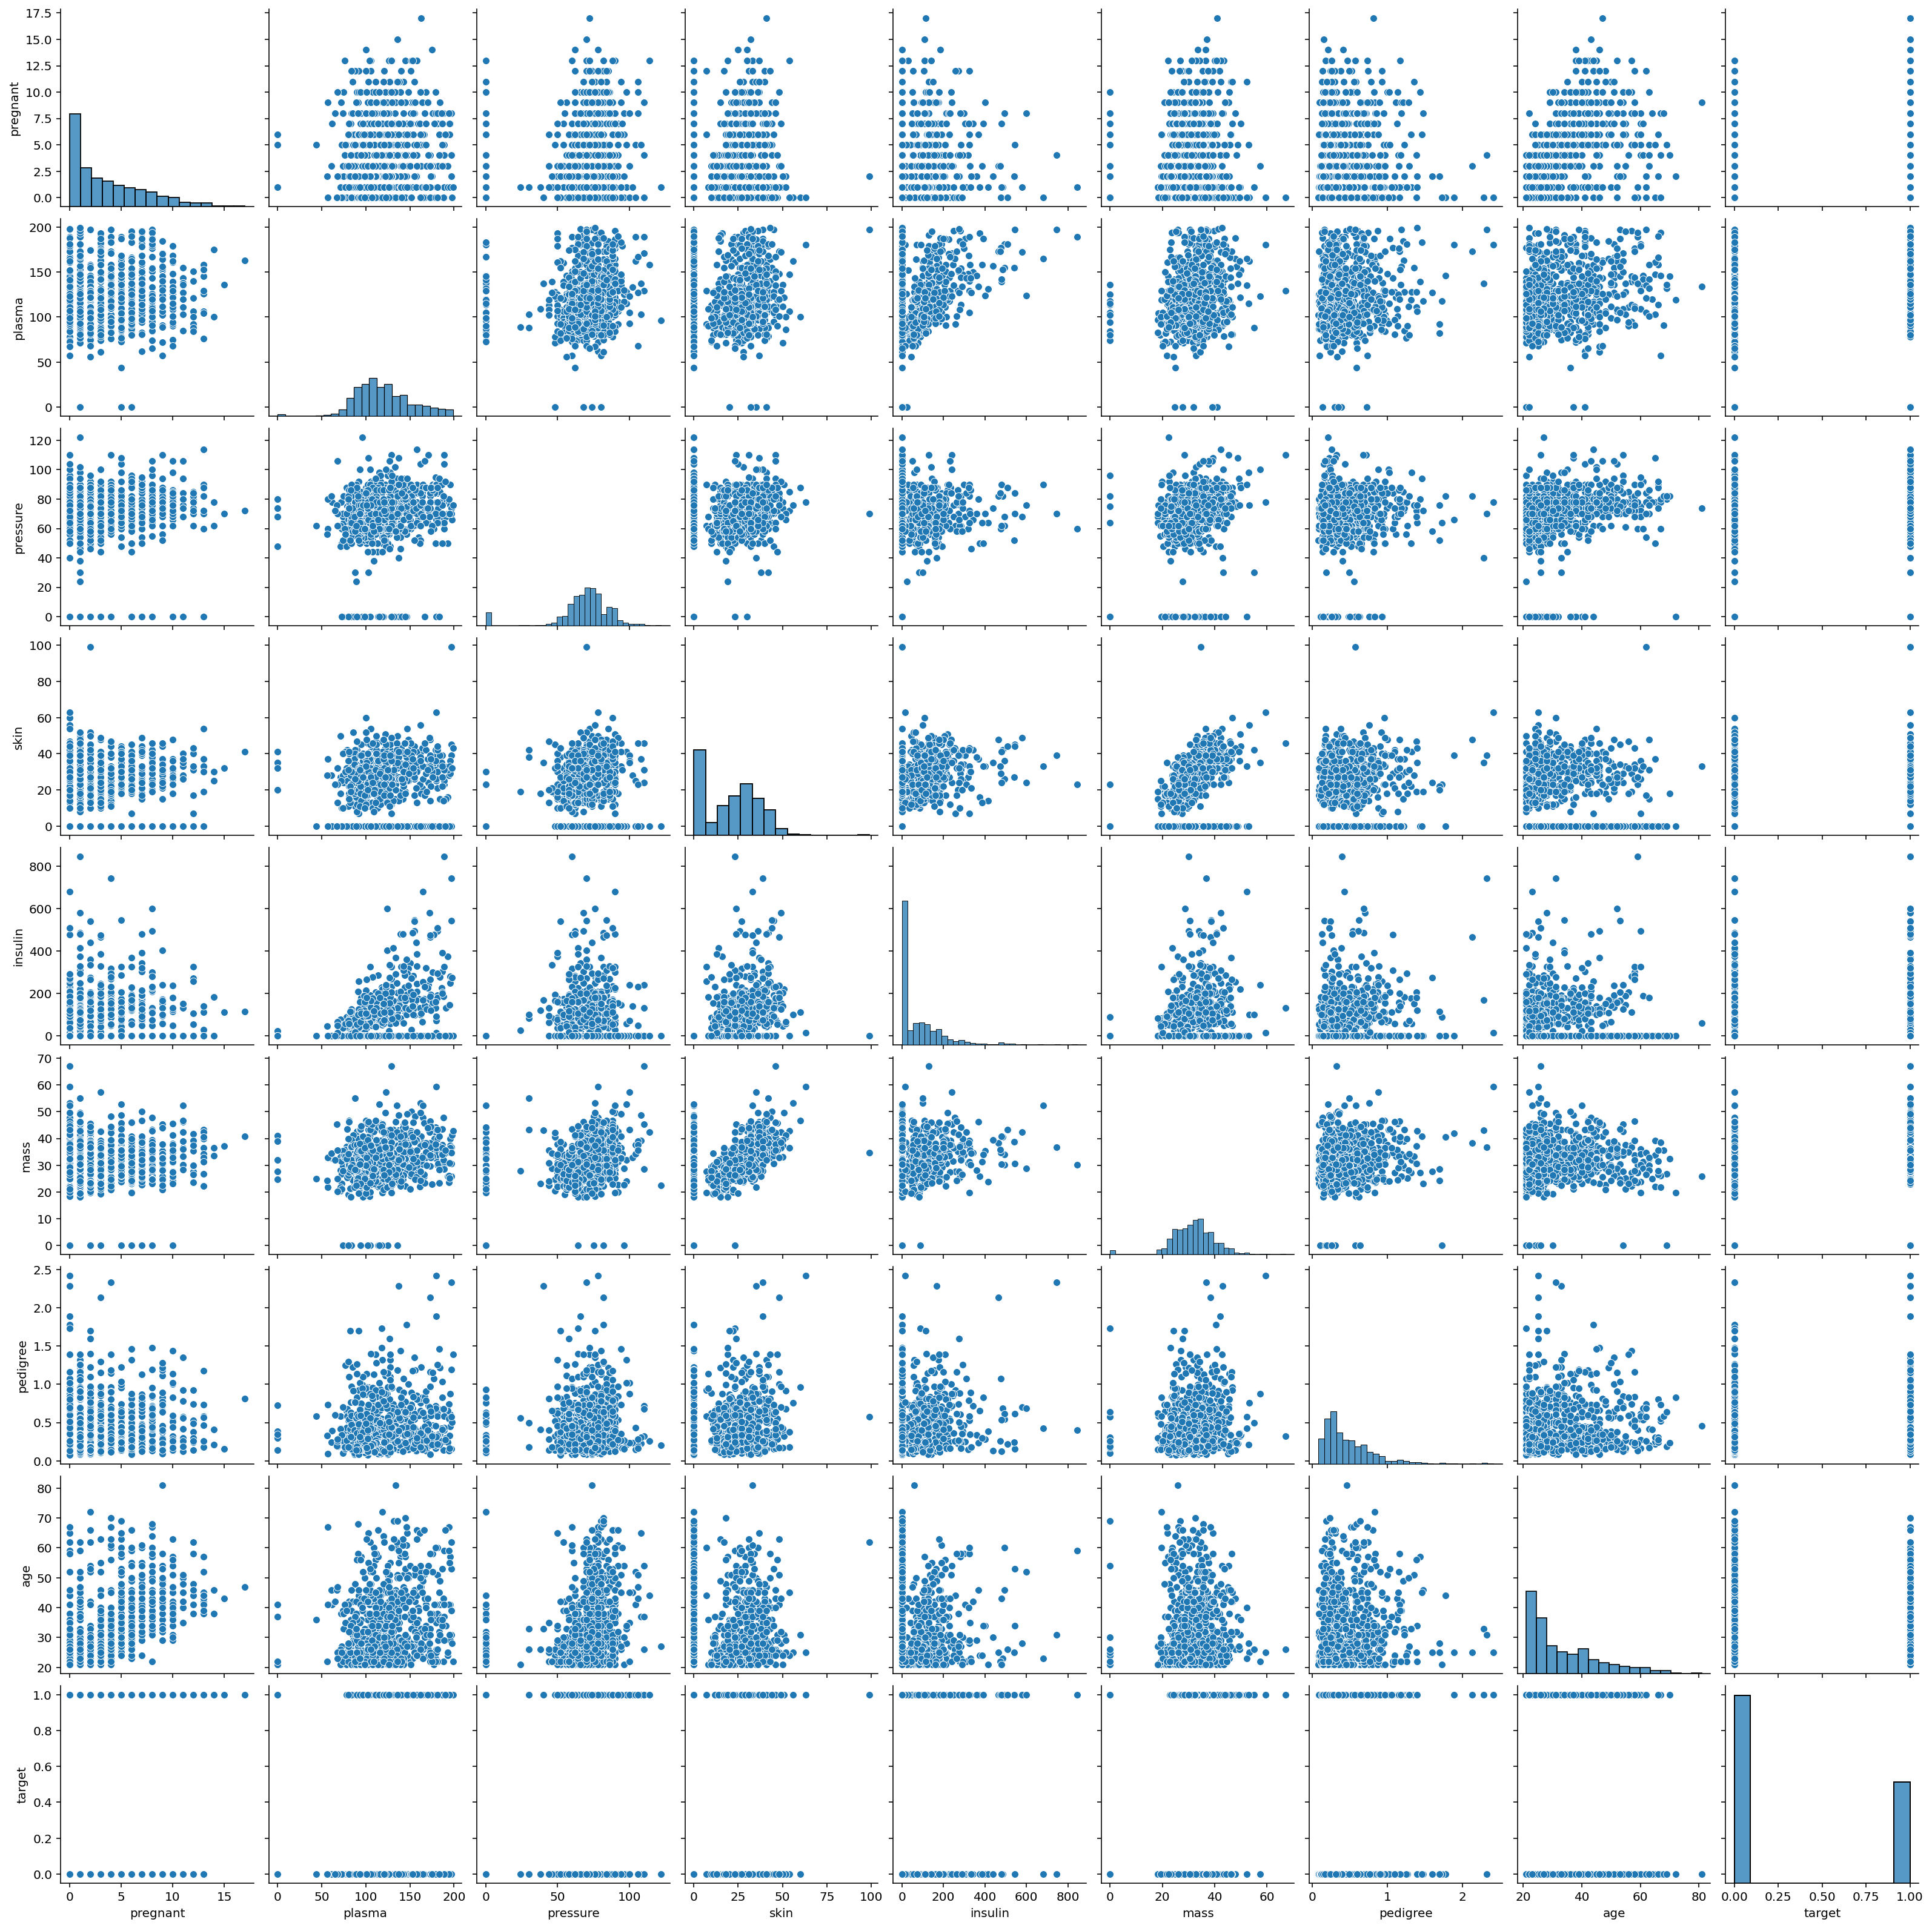

In [31]:
sns.pairplot(ds);

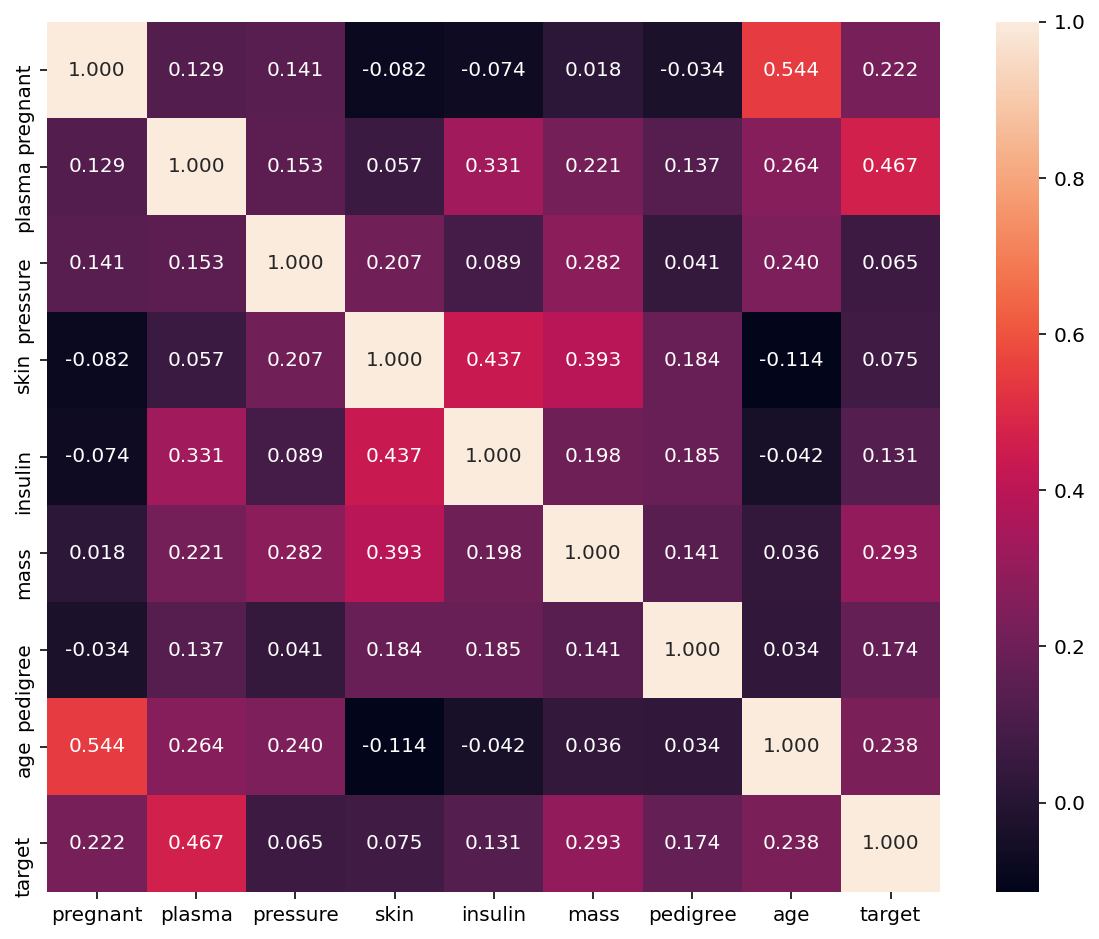

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(ds.corr(), annot=True, fmt='.3f'); # строим матрицу корреялции

In [41]:
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['target'], axis=1), 
                                                    ds['target'], 
                                                    test_size=0.3, 
                                                    random_state=17
                                                   )

In [43]:
transformer = PowerTransformer(standardize=True) # нормализация и стандартизация
x_train = transformer.fit_transform(x_train)
x_test = transformer.transform(x_test)

Посмотрим как работают индивидуальные модели на кросс-валидации:

In [60]:
def get_cross_val_score(x, y, model, cv):
    """Функция для оценки модели на кросс-валидации"""
    cv_score = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1) # прогоняем модель на кросс-валидации
    print(model.__class__.__name__)
    print('Точность модели на кросс-валидации: %.3f+-%.3f'% (np.mean(cv_score), np.std(cv_score)))

In [115]:
# рассматриваемые модели
log_reg = LogisticRegression(random_state=17)
svc = SVC(random_state=17)
rfc = RandomForestClassifier(random_state=17)
nb = BernoulliNB()

skf = StratifiedKFold(n_splits=7) # схема для кросс-валидации

for model in [
    log_reg,
    svc,
    rfc,
    nb
]:
    get_cross_val_score(x_train, y_train, model, skf) # получим результаты на кросс-валидации
    

LogisticRegression
Точность модели на кросс-валидации: 0.756+-0.040
SVC
Точность модели на кросс-валидации: 0.752+-0.062
RandomForestClassifier
Точность модели на кросс-валидации: 0.771+-0.059
BernoulliNB
Точность модели на кросс-валидации: 0.715+-0.054


In [116]:
for model in [
    log_reg,
    svc,
    rfc,
    nb
]:
    model.fit(x_train, y_train)
    print(model.__class__.__name__)
    print('Точность модели на тестовой выборке: %.3f' % accuracy_score(y_test, model.predict(x_test)))

LogisticRegression
Точность модели на тестовой выборке: 0.762
SVC
Точность модели на тестовой выборке: 0.784
RandomForestClassifier
Точность модели на тестовой выборке: 0.779
BernoulliNB
Точность модели на тестовой выборке: 0.719


### Bagging classifier

In [117]:
bagging = BaggingClassifier(base_estimator=svc, n_jobs=-1, random_state=17)

In [118]:
cv_score = cross_val_score(bagging, x_train, y_train, 
                           scoring='accuracy', cv=skf, n_jobs=-1) # прогоняем модель на кросс-валидации
print('Точность модели на кросс-валидации: %.3f+-%.3f'% (np.mean(cv_score), np.std(cv_score)))


Точность модели на кросс-валидации: 0.767+-0.057


In [119]:
bagging.fit(x_train, y_train)
print('Точность модели на тестовой выборке: %.3f' % accuracy_score(y_test, bagging.predict(x_test)))

Точность модели на тестовой выборке: 0.775


### Voting classifier

In [120]:
svc = SVC(random_state=17, probability=True)
voting = VotingClassifier(
    estimators=[('lr', log_reg), ('svc', svc), ('rfc', rfc), ('nb', nb)], 
    voting='soft', 
    weights=(1,1,1,1),
    n_jobs=-1
)

In [121]:
cv_score = cross_val_score(voting, x_train, y_train, 
                           scoring='accuracy', cv=skf, n_jobs=-1) # прогоняем модель на кросс-валидации
print('Точность модели на кросс-валидации: %.3f+-%.3f'% (np.mean(cv_score), np.std(cv_score)))

Точность модели на кросс-валидации: 0.767+-0.057


In [122]:
voting.fit(x_train, y_train)
print('Точность модели на тестовой выборке: %.3f' % accuracy_score(y_test, voting.predict(x_test)))

Точность модели на тестовой выборке: 0.771


### Stacking classifier

In [123]:
stacking = StackingClassifier(
    estimators=[('svc', svc), ('rfc', rfc), ('nb', nb)], 
    final_estimator=log_reg,
    cv = skf,
    n_jobs=-1
)

In [124]:
cv_score = cross_val_score(stacking, x_train, y_train, 
                           scoring='accuracy', cv=skf, n_jobs=-1) # прогоняем модель на кросс-валидации
print('Точность модели на кросс-валидации: %.3f+-%.3f'% (np.mean(cv_score), np.std(cv_score)))

Точность модели на кросс-валидации: 0.769+-0.050


In [125]:
stacking.fit(x_train, y_train)
print('Точность модели на тестовой выборке: %.3f' % accuracy_score(y_test, voting.predict(x_test)))

Точность модели на тестовой выборке: 0.771


В данном примере мы не наблюдаем значительной прибавки в точности, в связи с тем, что датасет достаточно простой. Для более сложных датасетов чаще всего разница между одиночными моделями и ансамблями существенна.